In [1]:
### Importer les modules ###
import os
import psf
import glob
import scipy
import pylab
import poppy
import tables
import pyphot
import astropy
import numpy as np
from scipy import signal
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift

In [2]:
### Average resolution ###
R_u = 4995
R_g = 4634
R_r = 4633
R_i = 4601
# sigma
dR_u = 1059
dR_g = 890
dR_r = 909
dR_i = 878

# delta lambda - limit of resolution = lambda/R

N_pas = 100000

### wavelength range ### (nm)
u = np.linspace(350.0,440.0,N_pas)
g = np.linspace(427.0,545.0,N_pas)
r = np.linspace(522.0,680.0,N_pas)
i = np.linspace(656.0,850.0,N_pas)

### Throughput ###
# Total expected
Thr_u = 0.741
Thr_g = 0.737
Thr_r = 0.749
Thr_i = 0.726
# w/ contingency at 2% to all estimates
thr_u = 0.643
thr_g = 0.627
thr_r = 0.663
thr_i = 0.630

# Line Density (lines/mm) -> (lines/nm)
ld_u = 3380*10**-6
ld_g = 2655*10**-6
ld_r = 2070*10**-6
ld_i = 1660*10**-6

# Line Spacing d = Line Density ^-1
d_u = ld_u**-1
d_g = ld_g**-1
d_r = ld_r**-1
d_i = ld_i**-1

# Feed Angle
alpha = 41*np.pi/180. # ◦ -> rad 

# lambda Littrow (nm)
ll_u = 388.2
ll_g = 494.2
ll_r = 633.9
ll_i = 790.4

# pixel (m) detector 2k x 4k
pix_x = 15*10**-6
pix_y = 15*10**-6

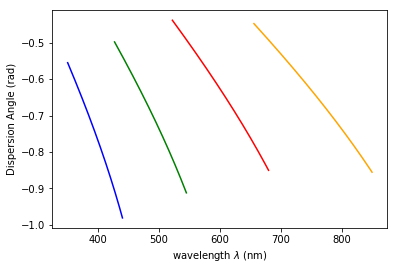

In [3]:
# Dispersion Angle (m=1)
da_u = np.arcsin(np.sin(alpha) - u*ld_u)
da_g = np.arcsin(np.sin(alpha) - g*ld_g)
da_r = np.arcsin(np.sin(alpha) - r*ld_r)
da_i = np.arcsin(np.sin(alpha) - i*ld_i)
plt.xlabel("wavelength $\lambda$ (nm)")
plt.ylabel("Dispersion Angle (rad)")
plt.plot(u,da_u,'b')
plt.plot(g,da_g,'g')
plt.plot(r,da_r,'r')
plt.plot(i,da_i,'orange')

In [4]:
# position en plan d'image



In [5]:
# Basic black-body spectrum plot
h = 6.62606885e-34 # Planck constant
c = 2.99792458e+8  # speed of light
k = 1.38064852e-23 # Boltzmann constant

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity



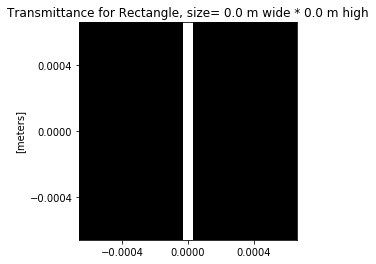

In [15]:
# For SOXS UV-VIS :
# slit scale : 110µm/arcsec
# widths : 0.5 - 1.0 - 1.5 - 5.0 arcsec
# slit height : 12 arcsec
width = 0.5 * 110*1e-6
height = 12 * 110*1e-6
ap = poppy.RectangleAperture(width=width, height=height)
ap.display(colorbar=False)

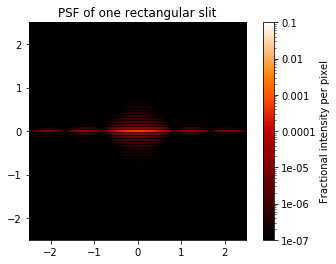

In [24]:
osys = poppy.OpticalSystem()
osys.add_pupil(poppy.RectangleAperture(width=0.5, height=12.))
osys.add_detector(pixelscale=0.010, fov_arcsec=5.0)
psf = osys.calc_psf(2e-6)                            # wavelength in microns
poppy.utils.display_psf(psf, title='PSF of one rectangular slit')

In [8]:
Collimateur_EFL = 272.55 # mm
Collimateur_RFL = 292.12 # mm, reflected focal length
Camera_FL = 140 # mm, camera's focal length
# Dispersion Angle (m=1)
# to make things easier, start with Onde monochromatique
lamda_mono = 5000*1e-10 # Å -> m
ld_g = 2655*1e3 #(lines/mm) -> (lines/m)
alpha = 41*np.pi/180. # ◦ -> rad, Feed Angle
dis_ang = np.arcsin(np.sin(alpha) - lamda_mono*ld_g) # 5000 Å is inside g's range
resp_spec = Collimateur_RFL*dis_ang  # spectral response

In [9]:
# np.convolve(psf,resp_spec)

In [10]:
astropy.io.fits.hdu.hdulist.HDUList.readall(psf)

In [11]:
args = dict(shape=(32, 32), dims=(4, 4), ex_wavelen=488, em_wavelen=520,
            num_aperture=1.2, refr_index=1.333,
            pinhole_radius=0.55, pinhole_shape='round')
obsvol = psf.PSF(psf.GAUSSIAN | psf.CONFOCAL, **args)
print('%.5f, %.5f' % obsvol.sigma.ou)

obsvol = psf.PSF(psf.ISOTROPIC | psf.CONFOCAL, **args)
obsvol[0, :3]

# save the image plane to file
obsvol.slice(0).tofile('_test_slice.bin')
# save a full 3D PSF volume to file
obsvol.volume().tofile('_test_volume.bin')

AttributeError: 'HDUList' object has no attribute 'PSF'